# CM3070 Final Project, Modelling

```
University of London
BSc Computer Science
CM3070, Final Project
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```

## 1. Introduction

The ERC model we aspire to develop, namely **HLM12ERC**, is a multi-modal machine learning model, trained to infer emotions through textual, visual, and audio inputs. To achieve this, we employ some popular or state-of-the-art ML techniques from the fields of Natural Language Processing, Computer Vision and Signal Processing. The resulting system will be a versatile model capable of identifying and classifying emotional states on datasets of similar data distributions to the MELD dataset, which we use for training and evaluation.

As machine learning practitioners, we appreciate the importance of adhering to structured, proven workflows that provide a roadmap for complex projects, guiding us through the essential steps from data acquisition to model evaluation and deployment. Chollet's workflow, also known as "Universal Machine Learning Workflow"[4] provides us with this roadmap, establishing an effective and efficient framework for our ERC model development endeavour.

Several steps of the present MLOps Pipeline leverage a custom-built `hlm12erc` library, specifically designed to streamline data manipulation, model training, evaluation, and serving procedures for this project.

Join us on this journey as we explore, innovate, and strive to advance the frontiers of emotion recognition technology.

## 2. Environment

In this section of our project, we delve into the technical groundwork, outlining the structuring of our dependencies, initializing key system configurations and paths that will be leveraged throughout the ensuing stages.

At the heart of this setup is the setup.cfg file, which lists our project's dependencies and facilitates the seamless installation of our custom-built **`hlm12erc`** library. By using the `-e` option for pip, we unlock dynamic editing capabilities for the library's codebase without requiring repeated reinstallation.

To optimise our system, we've crafted different sets of dependencies for each critical task, including `etl`, `eda`, `modelling`, `training`, and `serving`, allowing us to avoid redundant installations in environments where certain packages aren't needed. We also establish specific log levels and configure Jupyter's `auto-reload` mechanisms, empowering us with real-time updates and valuable debugging insights.

### 2.1. Dependencies

In [1]:
!cat ../setup.cfg

[metadata]
name = hlm12erc
version = attr: hlm12erc.VERSION
author = Hudson Mendes
author_email = hlm12@student.london.ac.uk
description = Final Project from University of London
long_description = file: README.md, LICENSE
keywords = university-of-london
license = copyright

[options]
zip_safe = False
include_package_data = True
packages = find:
package_dir =
    =src
python_requires = >=3.10
install_requires =
    torch>=2.0.1
    torchtext>=0.15.2
    torchvision>=0.15.2
    transformers>=4.30.2
    nltk>=3.8.1
    Pillow>=10.0.0
    scikit-learn>=1.3.0

[options.package_data]

[options.extras_require]
# development
dev =
    pre-commit>=3.3.3
    black[jupyter]>=23.7.0
    isort>=5.12.0

test =
    pytest>=7.4.0

# mlops
etl =
    # extract, transformation & loading
    kaggle>=1.5.13
    tqdm>=4.65.0
    pandas>=2.0.1
    google-cloud-storage>=2.10.0
    moviepy>=1.0.3

eda =
    # exploratory data analysis, and model design
    gensim
    tensorflow
    tensorflow-hub
    torch
  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

### 2.2. Paths & Locations

In [4]:
import pathlib

dir_home = pathlib.Path("../")
dir_data = dir_home / "data"
dir_target = dir_home / "target"
dir_config = dir_home / "config"

## 3. Defining the Problem

Emotion Recognition in Conversations (ERC) refers to the process of recognising and analysing emotions in interactive dialogues. It presents a unique set of challenges given the fact that the same words or phrases could convey different emotions depending on the context and flow of the conversation. This task is further complicated when applied in non-dyadic settings, where multiple participants engage in a dialogue. This makes ERC a complex problem within the realm of machine learning and artificial intelligence, where context modelling and emotional shifts among interlocutors are difficult to address accurately.

Despite its complexity, ERC has garnered significant interest owing to its vast applications in opinion mining over social media threads, chat history, and other online platforms. The ability to accurately discern emotions in conversations can have profound implications for various industries, making any advancements in this field potentially groundbreaking. However, given the sparsity of the solution space and the high variability in model architecture, ERC remains a largely unexplored area with many potential paths for future research and experimentation.

### 3.2. Multi-Party Setting Challenge

Multi-party conversations present an inherent set of challenges when it comes to emotion recognition (ERC). In a dialogue involving multiple participants, the context, conversation flow, and emotional shifts become considerably more intricate to decipher. The utterances in multi-party dialogues can express a wide range of emotions based on the context, making the task of accurate emotion recognition more arduous. This problem of contextual modelling and accounting for emotion shifts among multiple interlocutors remains a significant challenge in ERC. Additionally, the complex dynamics of multi-party conversations and the interdependence of individual emotional states further complicate the task.

The multi-modality of ERC data also poses another layer of challenge in multi-party settings. As emotions can only be detected through human actions such as textual utterances, visual gestures, and acoustic signals in the absence of physiological indications, the need for effectively dealing with multi-modal data becomes crucial. While some models focus on exploring this multi-modality, others resort to using a single modality, usually textual, thereby ignoring valuable insights that could be gleaned from other modalities. Consequently, the architectural variations in the existing models, coupled with the largely unexplored solution space, underscore the daunting challenges of emotion recognition in multi-party settings.

### 3.3. Multi-modality Challenge

The multifaceted challenge of Emotion Recognition in Conversations (ERC) is magnified by the multi-modal nature of the data involved. ERC data typically consists of multiple modalities, such as textual utterances, visual cues, and acoustic signals. Accurately detecting emotions from these varied sources is complex, as they can individually or collectively contribute to the overall emotional context. This complexity is amplified by the high-dimensionality of the data, particularly in video and audio modalities. This high-dimensional data is both difficult to investigate and expensive to compute, posing significant challenges in data handling, processing, and analysis.

Furthermore, the computation and training of multi-modal models are exceptionally resource-intensive. Each modality may require distinct computational approaches and algorithms for processing and analyzing the data, increasing the overall computational load. Training such models also necessitates substantial computational power and time, often leading to increased costs and resource allocation. These factors, combined with the diverse architectures proposed to model ERC, contribute to the intricate and computationally demanding nature of emotion recognition. Despite the high costs and complexity, the vast potential applications of accurate ERC underscore the importance of ongoing research in this challenging, yet highly rewarding, field of machine learning.

## 4. Assembling the DataSet

This section of the document focuses on assembling the final dataset that will be used for training and evaluating machine learning models. This involves performing ETL (Extract, Transform, Load) operations on the raw MELD data[1, 2] to prepare it for modelling. ETL is a process used to extract data from various sources, transform it into a format that is suitable for analysis, and load it into a target database or data warehouse. In this section, the raw data is extracted from various sources, transformed into a format that can be used for modelling, and loaded into a Pandas DataFrame.

The code in this section is responsible for assembling the final dataset by combining the preprocessed text, audio, and visual features for each example. The `hlm12erc` library is used to load the preprocessed features for each example and combine them into a single DataFrame. This library was created specifically for this project to simplify the notebook code by abstracting the ETL complexity into a simple, well-tested library that could be reused and scheduled if needed. The library was designed with full unit-test coverage to ensure that the data is loaded and combined correctly. The resulting DataFrame contains the preprocessed features for each example, as well as the corresponding label, which will be used for training and evaluating the machine learning models.

### 4.1. Installing ETL Dependencies



In [5]:
%%capture
%pip install -e '..[etl]'

### 4.2. Running ETL

In [6]:
from hlm12erc.etl import ETL, KaggleDataset

ds_kaggle = KaggleDataset(owner="zaber666", name="meld-dataset", subdir="MELD-RAW/MELD.Raw")
etl = ETL(dataset=ds_kaggle).into(uri_or_folderpath=dir_data)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:hlm12erc.etl:Kaggle dataset: zaber666/meld-dataset
INFO:hlm12erc.etl:Workspace set to: /tmp/hlm12erc/etl
INFO:hlm12erc.etl:Dataset already loaded into ../data, skipping (use force=True to force re-load).


### 4.3. Previewing Data Loaded

In [7]:
!ls {str(dir_data)} | head -n 10

d-0-seq-0.png
d-0-seq-0.wav
d-0-seq-1.png
d-0-seq-1.wav
d-0-seq-10.png
d-0-seq-10.wav
d-0-seq-11.png
d-0-seq-11.wav
d-0-seq-12.png
d-0-seq-12.wav


In [8]:
import pandas as pd

df_raw = pd.read_csv(dir_data / "train.csv", index_col=0)
df_raw

,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...
9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Rachel,"No, but I was doing my thing and everything was going according to the plan!",,,anger
Joey,"Then I called 9-1-1 and they laughed at me, if this isnt an emergency, then what is?",,,anger
Phoebe,Come on!,,,anger
Phoebe,I know. Use it.,,,disgust
Monica,Please! I am not as bad as Ross.,,,disgust
Rachel,"I mean that aint a pretty picture in the morning, yknow what I mean.",,,disgust
Rachel,Oh no,,,fear
Another Scientist,And I need to flip the light switch on and off 17 times before I leave a room or my family will die.,,,fear
Phoebe,"No, dont look directly at them!",,,fear
Chandler,Tulsa is heaven!,,,joy

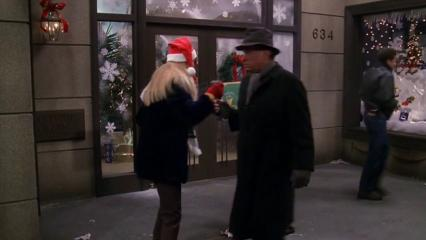
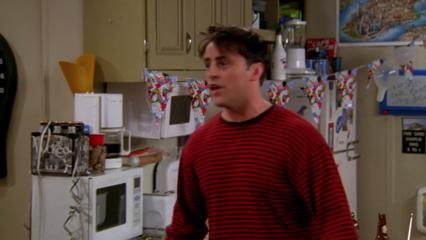
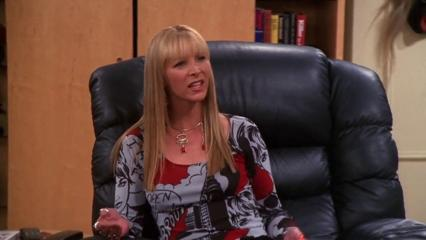
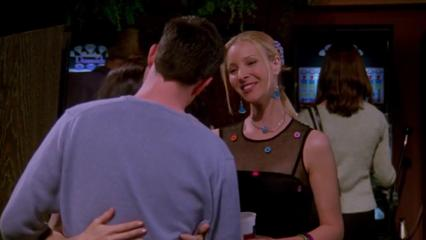
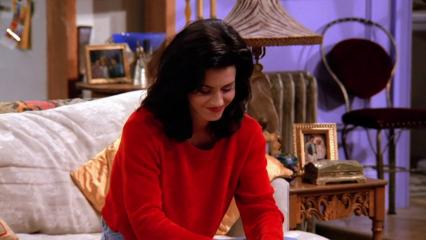
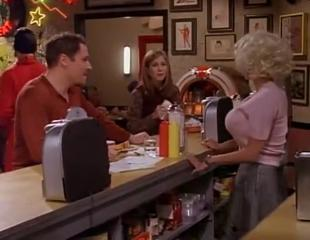
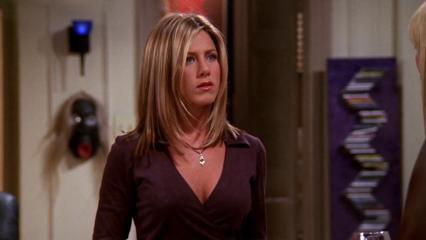
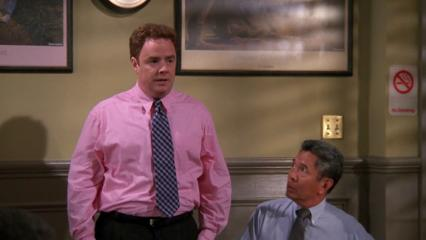
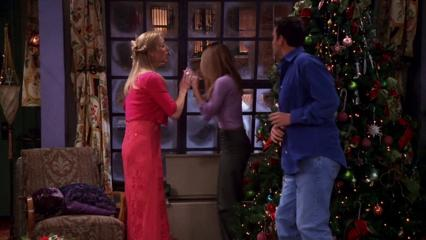
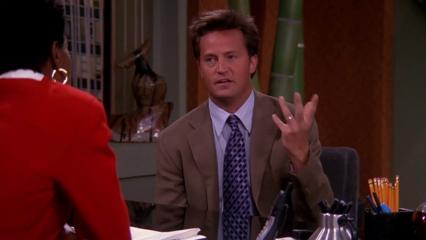
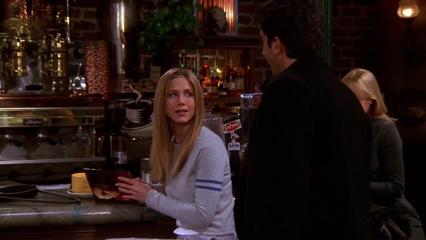
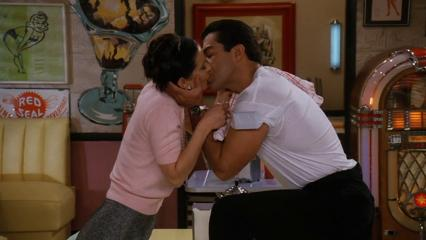
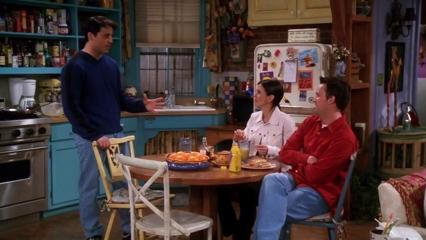
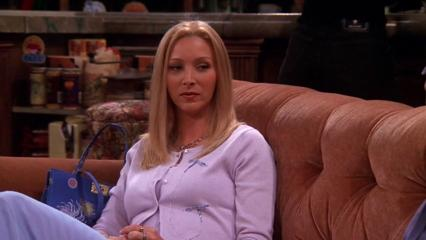
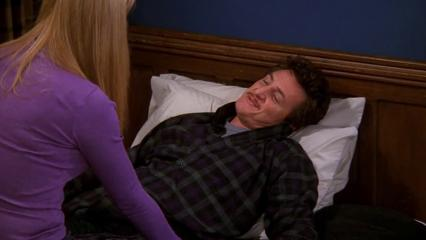
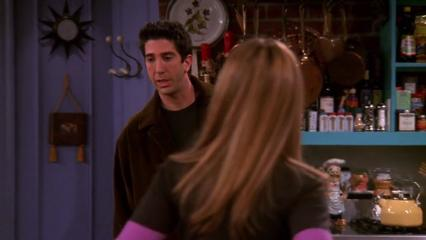
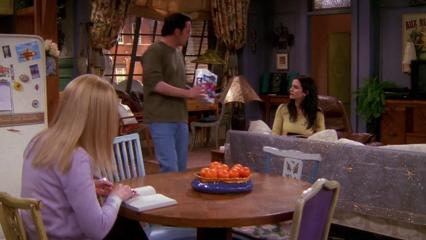
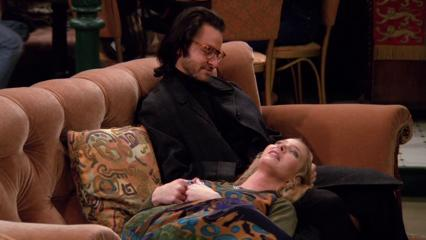
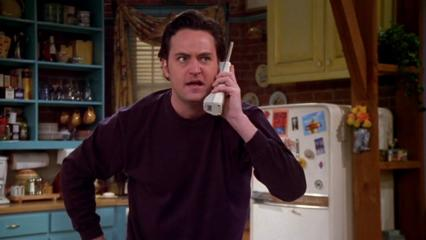
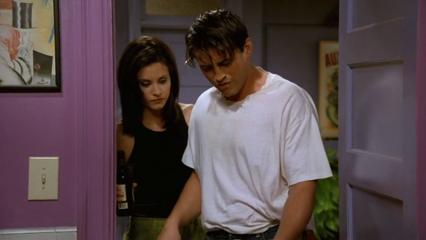
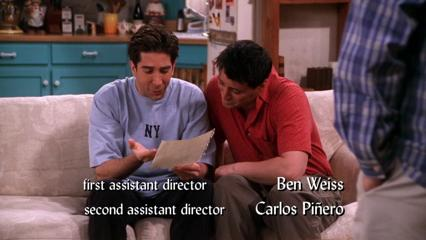

In [9]:
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = df_raw.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{dir_data / row["x_audio"]}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

## 5. Choosing the Metric of Success

The chosen metric of success for the **HLM12ERC** project, as outlined in the document, is **`Accuracy`**, in the form it's calculated by the `scikit-learn` library[3].

The document establishes the criteria for comparative success between different approaches, such as Advanced Textual Embeddings, based on their ability to achieve superior Accuracy scores over the MELD Test Split. This choice clearly aligns with the principles described by Francois Chollet in "Choosing the Metric of Success"[4], where the selection of a suitable metric is vital for effectively guiding the optimization of machine learning models and for a fair comparative analysis of different methods.

## 6. Deciding on the Evaluation Protocol

The evaluation protocol for the **HLM12ERC** project adopts the **`Hold Out Test-set`** approach, a decision influenced by the structure of the MELD Dataset and the constraints imposed by its size and multimodal nature. This dataset comes pre-divided into three splits: `train`, `dev`, and `test`, which directly supports the implementation of the Hold Out approach.

The choice of this protocol is further justified due to the impracticability of using methods like K-Fold Cross Validation, stemming from the significant computational demands of the MELD dataset. In addition, the Hold Out Test-set approach serves as the evaluation standard for both individual components (Objectives 1 to 6) and the final model (Objective 7), ensuring consistent assessment throughout the development process.


## 7. Preparing your Data

The data preparation process in this code involves three main stages: (a) ETL (Extract, Transform, Load), (b) DataSet Loading, and (c) Data Collation for model training.

* **ETL:** This stage simplifies the dataset by extracting the data from a Kaggle source, transforming it into a 1st Normal Form (1NF) CSV table format, and loading it into a destination folder or Google Cloud Storage bucket. The ETL process makes the data easier to consume by the training process. The logic can be found in the `hlm12erc.etl` module, and it can also be run with a command-line instruction, and orchestrated through the `hlm12erc.etl.ETL` class.

* **DataSet Loading:** This stage wraps the data using PyTorch Data Utility Classes to shape it appropriately for consumption by the model trainer. This step ensures that the data is organized and can be efficiently fed into the training process. The dataset class is defined at `hlm12erc.training.MeldDataset`.

* **Data Collation:** The Data Collator is responsible for creating batches of data suitable for model training and evaluation. It takes a list of MeldRecord instances and collates the data into a dictionary format with keys like `x_text`, `x_visual`, `x_audio`, and `y_true`. The collation involves converting text, visual, and audio data into appropriate formats and encoding the labels using ERCLabelEncoder, making the data ready for consumption by the PyTorch model's "forward" method during both training and inference. The collator class is defined at `hlm12erc.training.ERCDataCollator`, and can be observed below.

In [10]:
%%capture
%pip install -e '..[training]'

In [11]:
import inspect
from hlm12erc.training import MeldDataset
from IPython.display import Code

class_code = inspect.getsource(MeldDataset)
Code(class_code, language="python")

  from .autonotebook import tqdm as notebook_tqdm

2023-08-02 16:01:28.440676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmpem9nb3wr
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmpem9nb3wr/_remote_module_non_scriptable.py


class MeldDataset(Dataset):
    """
    Using a dataframe to the dataset .csv file, this class allows access to
    the data in the high level form of a `MeldRecord` object, that already
    carries the visual features (PIL.Image) and audio features (wave.Wave).

    Example:
        >>> df = pd.read_csv("data/meld/train.csv")
        >>> dataset = MeldDataset(df)
        >>> record = dataset[0]
    """

    def __init__(self, filepath: pathlib.Path):
        """
        Creates a new instance of the MeldDataset for a split

        :param df: The dataframe containing the data for the split
        """
        self.filepath = filepath
        self.filedir = filepath.parent
        self.df = pd.read_csv(self.filepath).sort_values(by=["dialogue", "sequence"], ascending=[True, True])

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset, based on the length
        of the dataframe itself.

        :return: The number of samples in the dataset
        """
        return len(self.df)

    def __getitem__(self, index) -> MeldRecord:
        """
        Returns a single sample from the dataset, based on the index provided.
        The sample is returned in the form of a `MeldRecord` object, that
        already carries the visual features (PIL.Image) and audio features
        (wave.Wave)

        :param index: The index of the sample to be returned
        :return: A `MeldRecord` object containing the sample
        """
        row = self.df.iloc[index]
        dialogue = row["dialogue"]
        sequence = row["sequence"]
        previous_dialogue = self._extract_previous_dialogue(
            dialogue=dialogue,
            before=sequence,
        )
        return MeldRecord(
            speaker=row.speaker,
            visual=Image.open(str(self.filedir / row.x_visual)),
            audio=wave.open(str(self.filedir / row.x_audio)),
            previous_dialogue=previous_dialogue,
            utterance=row.x_text,
            label=row.label,
        )

    @property
    def classes(self) -> List[str]:
        """
        Returns a list of the classes in the dataset, based on the unique
        labels in the dataframe.

        :return: A list of the classes in the dataset
        """
        return sorted(self.df.label.unique().tolist())

    def _extract_previous_dialogue(self, dialogue: int, before: int) -> List[MeldDialogueEntry]:
        """
        Extracts the dialogue that happened before the current one, based on
        the dialogue number and the sequence number of the current dialogue.

        :param dialogue: The dialogue number of the current dialogue
        :param before: The sequence number of the current dialogue
        :return: The previous dialogue as a list of `MeldDialogueEntry`
        """
        previous_dialogue = self.df[(self.df.dialogue == dialogue) & (self.df.sequence < before)]
        return [MeldDialogueEntry(speaker=row.speaker, utterance=row.x_text) for _, row in previous_dialogue.iterrows()]

In [12]:
import inspect
from hlm12erc.training import ERCDataCollator
from IPython.display import Code

class_code = inspect.getsource(ERCDataCollator)
Code(class_code, language="python")

class ERCDataCollator:
    """
    Collates the data from the ERC dataset into a format that can be used and
    batched by the model, with multiple records turned into lists of its underlying
    datapoints.
    """

    def __init__(self, label_encoder: ERCLabelEncoder) -> None:
        """
        Initialise the ERCDataCollator class with the given ERCLabelEncoder object.

        :param label_encoder: ERCLabelEncoder object containing the label encoder
        """
        self.label_encoder = label_encoder

    def __call__(self, record: List[MeldRecord]) -> dict:
        """
        Collates the data from the ERC dataset into a format that can be used and
        batched by the model, with multiple records turned into lists of its underlying
        datapoints. We also encode the labels to make it easier to use in the model.

        :param record: The list of records to collate
        :return: The collated data
        """
        return {
            "x_text": [r.to_dialogue_prompt() for r in record],
            "x_visual": [r.visual for r in record],
            "x_audio": [r.audio for r in record],
            "y_true": self.label_encoder([r.label for r in record]),
        }

## 8. Model Selection

This section takes us from a baseline model to a final model through a rigorous set of experiments set out by the **Project Design** document as objectives.

We initially attempt to establish a baseline model with some basic approaches to the representation of each modality of the data, which serves as a starting point and upon which we shall iterate.

Then, we utilize a two-step process for each different experiment to evaluate whether we can produce a better model than the ones previously devised. First, a "Scaling up" phase aims to develop a model capable of overfitting the data, allowing deeper insights into its learning capacity and identifying areas for improvement. Second, a "Regularizing" phase addresses overfitting concerns through hyperparameter tuning. This iterative optimization ultimately leads to the final model that fulfills the success criteria and delivers superior performance on the MELD Test Split.

### Training & Evaluaton Utilities

In [13]:
from typing import Tuple
from hlm12erc.modelling import ERCModel
from hlm12erc.training import ERCConfigLoader, ERCTrainer, MeldDataset


def train_model(
    config: str,
    batch_size: int = 32,
    n_epochs: int = 25,
) -> Tuple[str, ERCModel]:
    """
    Train a model using the given configuration file and data files.

    :param config: Path to the configuration file.
    :param batch_size: Batch size.
    :param n_epochs: Number of epochs.
    :return: Trained model.
    """

    model_config = ERCConfigLoader(dir_config / f"{config}.yml").load()
    ds_train = MeldDataset(dir_data / "train.csv")
    ds_valid = MeldDataset(dir_data / "dev.csv")
    return ERCTrainer(model_config).train(
        data=(ds_train, ds_valid),
        batch_size=batch_size,
        n_epochs=n_epochs,
        save_to=(dir_target),
    )

In [ ]:
def display_train_valid_curves(model_name: str):
    """
    Reads the torch training metrics output to the `dir_target / model_name`
    folder and compiles a plot with 2 rows and 2 columns where the first row
    contains the training and validation loss curves and the second row
    contains the training and validation accuracy curves.
    """
    dir_model = dir_target / model_name
    

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


def evaluate_model(model):
    ds_test = MeldDataset(dir_data / "test.csv")
    y_pred = model.predict(ds_test)
    print(classification_report(ds_test.label, y_pred))
    print("Accuracy: ", accuracy_score(ds_test.label, y_pred))

### 8.1. Objective 1: Baseline Model

In [ ]:
baseline_model_name, baseline_model_instance = train_model("baseline")
display_train_valid_curves(baseline_model_name)
evaluate_model(baseline_model_instance)

### 8.2. Objective 2: Advanced Text Embeddings

### 8.3. Objective 3: Advanced Visual Embeddigns

### 8.4. Objective 4: Advanced Audio Embeddigns

### 8.5. Objective 5: Advanced Feature Fusion

### 8.6. Objective 6: Tripplet Contrastive Loss

## 9. Final Evaluation

## 10. Conclusions

## 11. References

[1] Soujanya Poria, Devamanyu Hazarika, Navonil Majumder, Gautam Naik, Erik Cambria, and Rada Mihalcea. 2019. MELD: A Multimodal Multi-Party Dataset for Emotion Recognition in Conversations. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics, Association for Computational Linguistics, Florence, Italy, 527–536. DOI:https://doi.org/10.18653/v1/P19-1050

[2] Chao-Chun Hsu, Sheng-Yeh Chen, Chuan-Chun Kuo, Ting-Hao Huang, and Lun-Wei Ku. 2018. EmotionLines: An Emotion Corpus of Multi-Party Conversations. In Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), Miyazaki, Japan. Retrieved from https://aclanthology.org/L18-1252

[3] F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M. Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, J. Vanderplas, A. Passos, D. Cournapeau, M. Brucher, M. Perrot, and E. Duchesnay. 2011. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12, (2011), 2825–2830.

[4] Francois Chollet. 2017. Deep Learning with Python (1st ed.), Manning Publications Co., USA.